# Photometry using astropy photutils and AAVSO comparison stars

## 1 Import dependencies and setup matplotlib

In [1]:
import requests, math, glob
import pandas as pd
import numpy as np
from photutils import DAOStarFinder
from astropy.stats import mad_std
from astropy.io import fits
from astropy.coordinates import SkyCoord
from astropy.wcs import WCS
import astropy.units as u
import matplotlib.pyplot as plt
from photutils import aperture_photometry, CircularAperture
from astroquery.simbad import Simbad
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
plt.style.use('seaborn')
pd.options.mode.chained_assignment = None 

## 2  Define input file, star name and comparason star range¶

In [2]:
FITS_FILE = '/home/dokeeffe/Pictures/CalibratedLight/2017-10-02/KIC08462852-2017-10-02-20-56-22Light_005.fits'
STAR_NAME = 'KIC08462852'
BRIGHTEST_COMPARISON_STAR_MAG = 11.0
DIMMEST_COMPARISON_STAR_MAG = 13.0


## 3 Define a function to download comparison stars from AAVSO. 

This will return a tuple containing an array and the chart ID.

In [3]:
def get_comp_stars(ra,dec,filter_band='V',field_of_view=18.5):
    result = []
    vsp_template = 'https://www.aavso.org/apps/vsp/api/chart/?format=json&fov={}&maglimit=18.5&ra={}&dec={}'
    print(vsp_template.format(field_of_view, ra, dec))
    r = requests.get(vsp_template.format(field_of_view, ra, dec))
    chart_id = r.json()['chartid']
    print('Downloaded Comparison Star Chart ID {}'.format(chart_id))
    for star in r.json()['photometry']:
        comparison = {}
        comparison['auid'] = star['auid']
        comparison['ra'] = star['ra']
        comparison['dec'] = star['dec']
        for band in star['bands']:
            if band['band'] == filter_band:
                comparison['vmag'] = band['mag']
                comparison['error'] = band['error']
        result.append(comparison)
    return result, chart_id

## 4 Download comparison stars and search simbad for our target.

Use astroquery to locate the RA/DEC of our target star.

Here we also define `results` which will be a collection of data progressivly enriched as we go


In [4]:
astroquery_results = Simbad.query_object(STAR_NAME)
TARGET_RA = str(astroquery_results[0]['RA'])
TARGET_DEC = str(astroquery_results[0]['DEC']).replace('+','').replace('-','')
results, chart_id = get_comp_stars(TARGET_RA, TARGET_DEC)
print('{} comp stars found'.format(len(results)))
results.append({'auid': 'target', 'ra': TARGET_RA, 'dec': TARGET_DEC})

results

https://www.aavso.org/apps/vsp/api/chart/?format=json&fov=18.5&maglimit=18.5&ra=20 06 15.4553&dec=44 27 24.793
Downloaded Comparison Star Chart ID X21328CWX
5 comp stars found


[{'auid': '000-BLS-551',
  'dec': '44:22:48.0',
  'error': 0.054,
  'ra': '20:06:48.09',
  'vmag': 11.263},
 {'auid': '000-BML-045',
  'dec': '44:27:05.0',
  'error': 0.036,
  'ra': '20:06:36.68',
  'vmag': 12.415},
 {'auid': '000-BLS-555',
  'dec': '44:30:54.0',
  'error': 0.05,
  'ra': '20:06:21.25',
  'vmag': 12.789},
 {'auid': '000-BML-046',
  'dec': '44:35:41.8',
  'error': 0.048,
  'ra': '20:06:53.14',
  'vmag': 12.983},
 {'auid': '000-BML-047',
  'dec': '44:25:53.7',
  'error': 0.038,
  'ra': '20:06:00.39',
  'vmag': 13.327},
 {'auid': 'target', 'dec': '44 27 24.793', 'ra': '20 06 15.4553'}]

## 5 Extract all sources from image

In [5]:
# extract sources from image and add details to comp_stars
fwhm = 3.0
source_snr = 20
hdulist = fits.open(FITS_FILE)
data = hdulist[0].data.astype(float)
header = hdulist[0].header
wcs = WCS(header)
bkg_sigma = mad_std(data)    
daofind = DAOStarFinder(fwhm=fwhm, threshold=source_snr*bkg_sigma)    
sources = daofind(data)

sources

id,xcentroid,ycentroid,sharpness,roundness1,roundness2,npix,sky,peak,flux,mag
int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
1,645.55658029,7.69908327045,0.45424855519,0.174645032246,0.355539480239,25.0,0.0,70365.2937781,28.269908551,-3.62831100903
2,1309.16598231,11.5995843996,0.44672872522,0.253701614478,0.497475903102,25.0,0.0,7287.61409036,2.85692255025,-1.13974616759
3,1375.65792899,11.9995956879,0.496571246411,0.185979847486,0.525493037437,25.0,0.0,3368.49664403,1.05632128534,-0.0594900777583
4,1122.94782151,16.7158994909,0.460102848306,-0.0896697826626,0.47276708619,25.0,0.0,8200.64521946,3.19746747319,-1.26201533809
5,1362.4645143,26.9619775656,0.433803791444,0.112942501751,0.429731153435,25.0,0.0,21372.8993241,8.4265184611,-2.31412044147
6,611.037214433,28.7876045811,0.401685842506,0.167921662456,0.419344081499,25.0,0.0,5478.05140726,1.98099565096,-0.742208805242
7,358.189493857,34.4617814911,0.503866132614,-0.00948179156524,0.26618329465,25.0,0.0,90850.6289014,34.2481732847,-3.83659353055
8,449.539598592,82.1069177762,0.379309325403,0.0980523701524,0.294225743108,25.0,0.0,7390.86311537,2.73814589578,-1.09364146198
9,964.423830549,83.9894147141,0.385366389308,0.120651000841,0.347913771591,25.0,0.0,3227.59162244,1.11273974981,-0.115984005994


## 6 Find the sources that correspond to our target and comparison stars

Any source within 4 arc seconds of a comparison star is considered a match. Here the `results` will be converted to a pandas dataframe and will now contain the x,y coords of the target and comparison stars.

In [6]:
for star in results:
    star_coord = SkyCoord(star['ra'],star['dec'], unit=(u.hourangle, u.deg))
    xy = SkyCoord.to_pixel(star_coord, wcs=wcs, origin=1)
    x = xy[0].item(0)
    y = xy[1].item(0)
    for source in sources:
        if(source['xcentroid']-4 < x < source['xcentroid']+4) and source['ycentroid']-4 < y < source['ycentroid']+4:
            star['x'] = x
            star['y'] = y
            star['peak'] = source['peak']
results = pd.DataFrame(results)
results

,auid,dec,error,peak,ra,vmag,x,y
0,000-BLS-551,44:22:48.0,0.054,19038.106969,20:06:48.09,11.263,388.415326,817.537270
1,000-BML-045,44:27:05.0,0.036,8153.566262,20:06:36.68,12.415,491.879800,617.615307
2,000-BLS-555,44:30:54.0,0.050,5919.023955,20:06:21.25,12.789,628.526243,440.515839
3,000-BML-046,44:35:41.8,0.048,4777.952321,20:06:53.14,12.983,365.886101,203.792448
4,000-BML-047,44:25:53.7,0.038,4538.973603,20:06:00.39,13.327,797.954483,683.615847
5,target,44 27 24.793,NaN,13457.943342,20 06 15.4553,NaN,672.395700,607.642881


## 7 Plot the image annotated with the comparsion stars
This is just to check everything looks ok

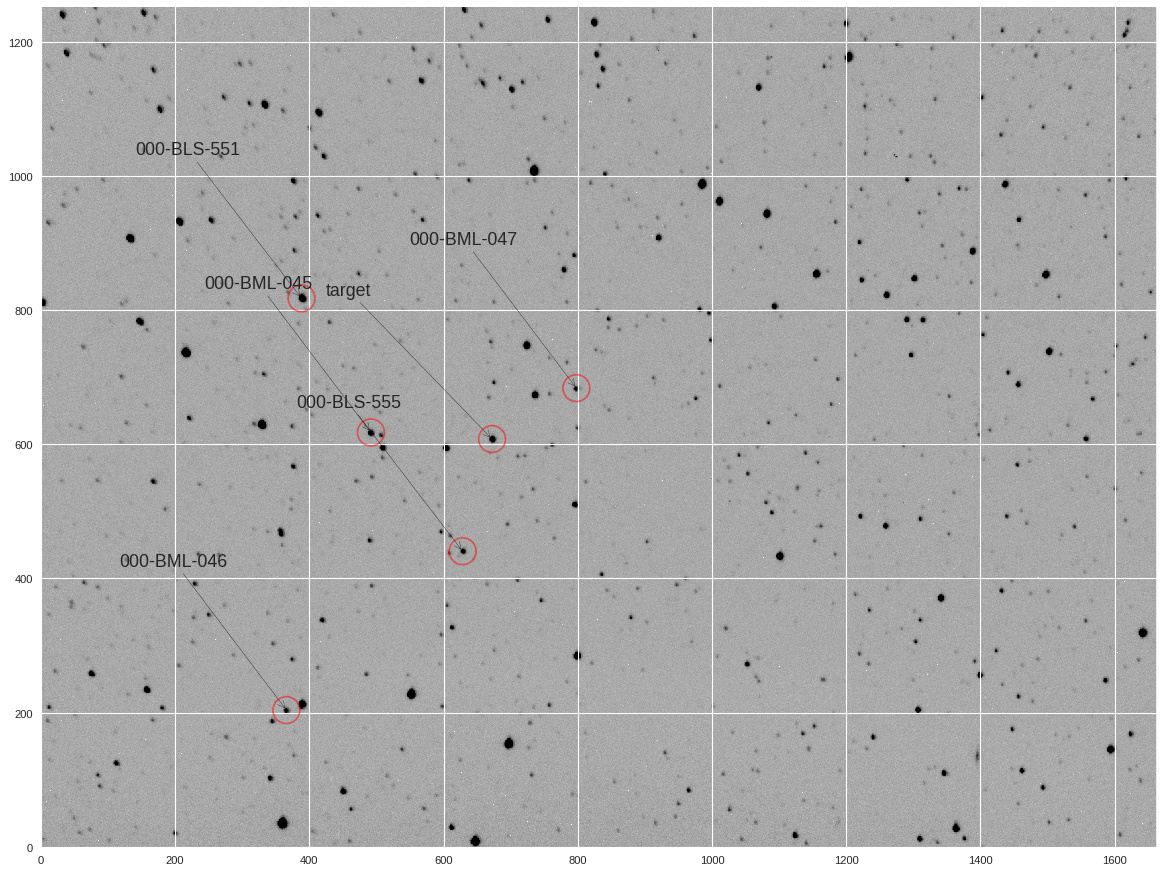

In [7]:
# plot the image with overlay
results = results.query('x > 0 and y > 0') 

hdulist = fits.open(FITS_FILE)
data = hdulist[0].data.astype(float)
fig=plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
positions = (results['x'], results['y'])    
position_apps = CircularAperture(positions, r=20.)    
# target_app = CircularAperture(target_xy, r=20.)    
plt.imshow(data, cmap='gray_r', origin='lower', vmin=0, vmax=2500)
position_apps.plot(color='red', lw=1.5, alpha=0.5)
# target_app.plot(color='blue', lw=1.5, alpha=0.5)
to_plot = results.query('peak < 50000 and vmag < 20 and vmag > 0') 
for to_annotate in results.iterrows():
    plt.annotate('{}'.format(to_annotate[1]['auid']),
        xy=(to_annotate[1]['x'], to_annotate[1]['y']), xycoords='data',
        xytext=(-150, 130), textcoords='offset points', size='16',
        arrowprops=dict(arrowstyle="->"))

## 8 Perform appeture photometry and add to the results
instrumental_mag is calculated as -2.5 * LOG10(`aperture_sum`)


In [8]:
aperture_radius =6.0
positions = (results['x'], results['y'])    
apertures = CircularAperture(positions, r=aperture_radius)    
phot_table = aperture_photometry(data, apertures)     
results['aperture_sum'] = phot_table['aperture_sum']
# add a col with calculation for instrumental mag
results['instrumental_mag'] = results.apply(lambda x: -2.5 * math.log10(x['aperture_sum']), axis = 1)
results

,auid,dec,error,peak,ra,vmag,x,y,aperture_sum,instrumental_mag
0,000-BLS-551,44:22:48.0,0.054,19038.106969,20:06:48.09,11.263,388.415326,817.537270,638097.456602,-14.512218
1,000-BML-045,44:27:05.0,0.036,8153.566262,20:06:36.68,12.415,491.879800,617.615307,294882.055471,-13.674121
2,000-BLS-555,44:30:54.0,0.050,5919.023955,20:06:21.25,12.789,628.526243,440.515839,231730.681287,-13.412459
3,000-BML-046,44:35:41.8,0.048,4777.952321,20:06:53.14,12.983,365.886101,203.792448,209482.247216,-13.302868
4,000-BML-047,44:25:53.7,0.038,4538.973603,20:06:00.39,13.327,797.954483,683.615847,185060.083314,-13.168282
5,target,44 27 24.793,NaN,13457.943342,20 06 15.4553,NaN,672.395700,607.642881,420098.911073,-14.058379


## 9 Compute the ensemble using the comparison stars.

**Use nunmpy linear regression on the comparison stars' vmag and instrumental_mag**

We should get a good linear fit with low residuals if the image is of good quality
Once we have the fit, feed the target instrumental_mag into the fit function to determine the magnitude.
Plot the results to visualise the data quality

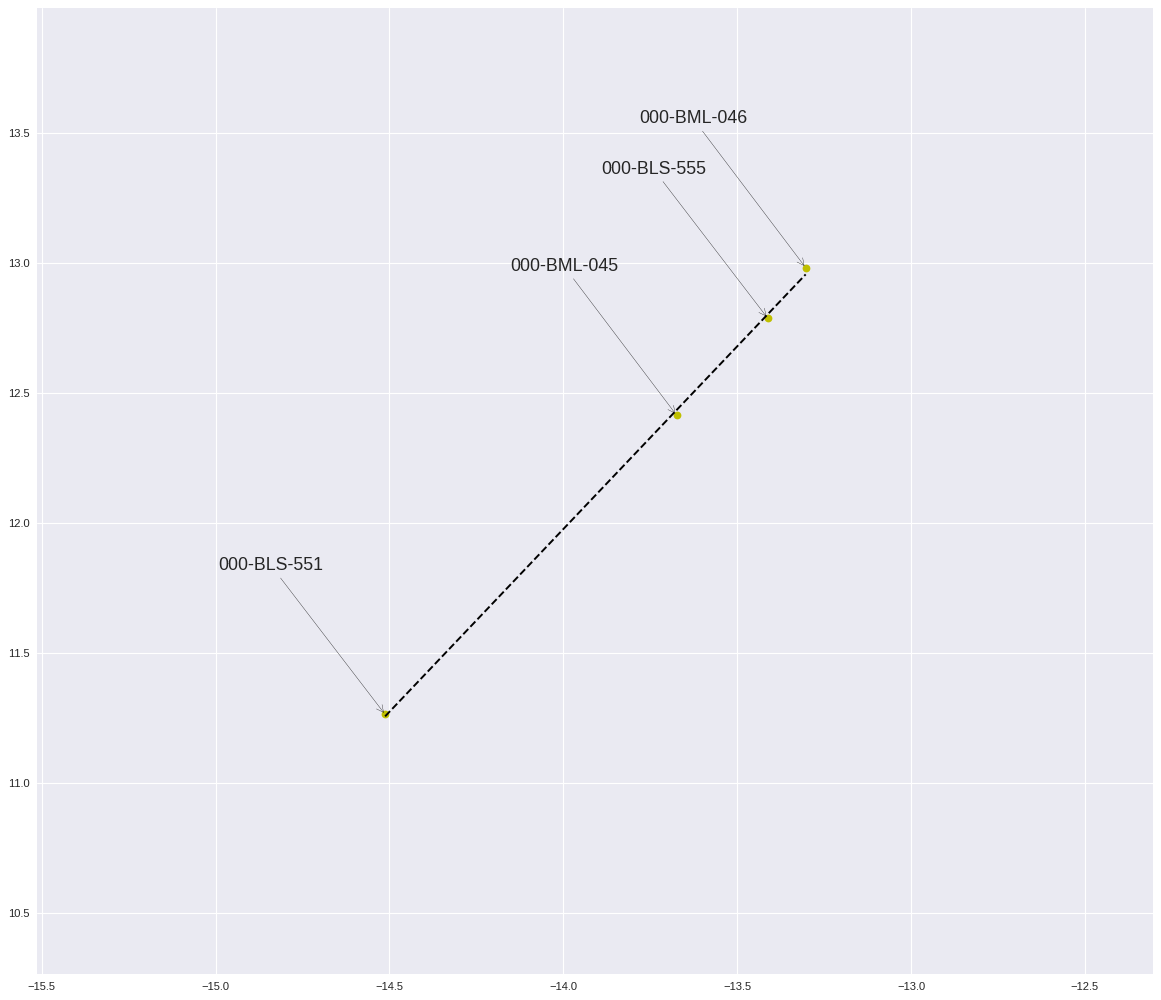

In [9]:
# now perform ensemble photometry by linear regression of the comparison stars' instrumental mags
to_linear_fit = results.query('auid != "target" and vmag > {} and vmag < {}'.format(BRIGHTEST_COMPARISON_STAR_MAG, DIMMEST_COMPARISON_STAR_MAG)) 
x = to_linear_fit['instrumental_mag'].values
y = to_linear_fit['vmag'].values
fit, residuals, rank, singular_values, rcond = np.polyfit(x, y, 1, full=True)
fit_fn = np.poly1d(fit) 
# fit_fn is now a function which takes in x and returns an estimate for y, 
# we use this later to calculate the target mag

#generate a plot to see the quality of the data
fig=plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(x,y, 'yo', x, fit_fn(x), '--k')
plt.xlim(np.min(x)-1, np.max(x)+1)
plt.ylim(np.min(y)-1, np.max(y)+1)
for to_annotate in to_linear_fit.iterrows():
    plt.annotate('{}'.format(to_annotate[1]['auid']),
        xy=(to_annotate[1]['instrumental_mag'], to_annotate[1]['vmag']), xycoords='data',
        xytext=(-150, 130), textcoords='offset points', size='16',
        arrowprops=dict(arrowstyle="->"))

## 10 Use the ensemble fit from above to calculate target mag

Plot again for a sanity check

Magnitude estimate: 11.894127782624818 error from residuals [ 0.0013096]


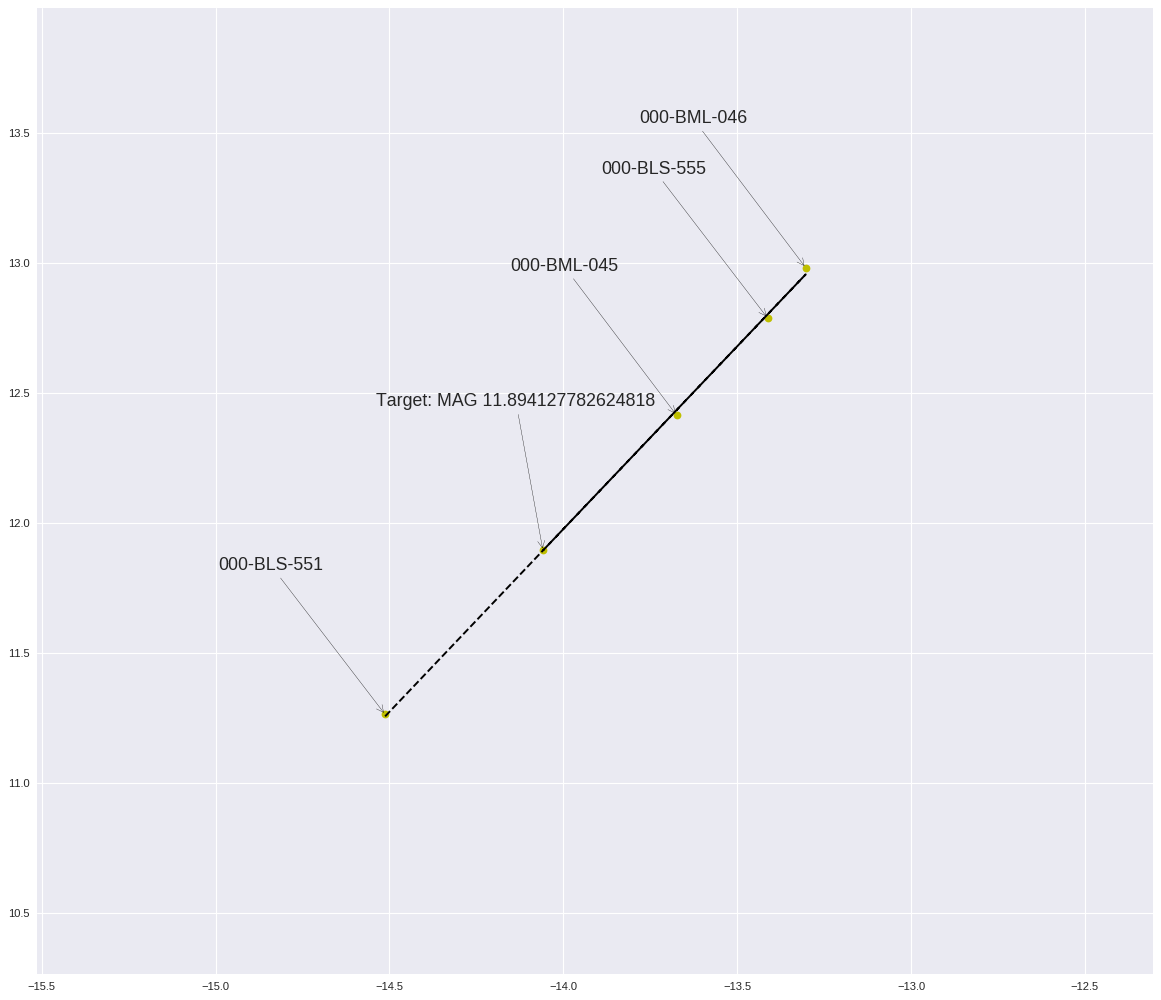

In [10]:

# fit_fn from above is a function which takes in x and returns an estimate for y, lets feed in the 'target' instrumental mag
target_instrumental_magnitude = results[results.auid=='target']['instrumental_mag'].values[0]
target_magnitude = fit_fn(target_instrumental_magnitude)
print('Magnitude estimate: {} error from residuals {}'.format(target_magnitude, residuals))
x = np.append(x,target_instrumental_magnitude)
y = np.append(y,target_magnitude)

fig=plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(x,y, 'yo', x, fit_fn(x), '--k')
plt.xlim(np.min(x)-1, np.max(x)+1)
plt.ylim(np.min(y)-1, np.max(y)+1)
plt.annotate('Target: MAG {}'.format(target_magnitude),
            xy=(target_instrumental_magnitude, target_magnitude), xycoords='data',
            xytext=(-150, 130), textcoords='offset points', size='16',
            arrowprops=dict(arrowstyle="->"))
for to_annotate in to_linear_fit.iterrows():
    plt.annotate('{}'.format(to_annotate[1]['auid']),
        xy=(to_annotate[1]['instrumental_mag'], to_annotate[1]['vmag']), xycoords='data',
        xytext=(-150, 130), textcoords='offset points', size='16',
        arrowprops=dict(arrowstyle="->"))

## 11 Use the ensemble to calculate a check star mag

Calculate the mag for a check star, lets pick 000-BML-045 from the plot above

In [15]:

check_star_instrumental_magnitude = results[results.auid=='000-BML-045']['instrumental_mag'].values[0]
check_magnitude = fit_fn(check_star_instrumental_magnitude)
print('Check star 000-BML-045 magnitude = {}'.format(check_magnitude))

Check star 000-BML-045 magnitude = 12.434656369385017


## 12 Summary for submission to AAVSO

In [16]:
observation_date = datetime.strptime(header['DATE-OBS'], '%Y-%m-%dT%H:%M:%S.%f')
print('Star Identifier: {}'.format(STAR_NAME))
print('Date-time : {}'.format(observation_date.strftime('%Y/%m/%d/%H/%M/%S')))
print('Magnitude: {} Error: {}'.format(target_magnitude, residuals))
print('Check Star 000-BML-045 Magnitude: {}'.format(check_magnitude))
print('Chart ID: {}'.format(chart_id))
print('Ensemble of {}. Error as residuals of linear fit'.format(to_linear_fit['auid'].values))

Star Identifier: KIC08462852
Date-time : 2017/10/02/20/56/22
Magnitude: 11.894127782624818 Error: [ 0.0013096]
Check Star 000-BML-045 Magnitude: 12.434656369385017
Chart ID: X21328CWX
Ensemble of ['000-BLS-551' '000-BML-045' '000-BLS-555' '000-BML-046']. Error as residuals of linear fit
